In [15]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# Exam Performance

In [16]:
# Is exam performance affected by type of schooling ?
data = pd.read_csv('exam_scores.csv')

In [17]:
group_stats = {
    'Groups': ['Home', 'Boarding', 'Regular'],
    'Count': [len(data['Home']), len(data['Boarding']), len(data['Regular'])],
    'Sum': [data['Home'].sum(), data['Boarding'].sum(), data['Regular'].sum()],
    'Average': [data['Home'].mean(), data['Boarding'].mean(), data['Regular'].mean()],
    'Variance': [data['Home'].var(), data['Boarding'].var(), data['Regular'].var()]
}
group_stats_df = pd.DataFrame(group_stats)
print(group_stats_df)

     Groups  Count   Sum    Average    Variance
0      Home     15  1182  78.800000  141.171429
1  Boarding     15  1078  71.866667   73.980952
2   Regular     15  1263  84.200000   50.457143


##### Null Hypothesis (H0): Exam performance is not affected by type of schooling

##### Alternative Hypothesis (H1): Type of schooling affects exam performance

In [18]:
from tabulate import tabulate
from scipy.stats import f

Home = data['Home']
Boarding = data['Boarding']
Regular = data['Regular']

k = 3
N = len(Home) + len(Boarding) + len(Regular)
group_means = [np.mean(Home), np.mean(Boarding), np.mean(Regular)]
grand_mean = np.mean([np.mean(Home), np.mean(Boarding), np.mean(Regular)])
SSb = sum([len(Home) * (group_means[0] - grand_mean) ** 2,
           len(Boarding) * (group_means[1] - grand_mean) ** 2,
           len(Regular) * (group_means[2] - grand_mean) ** 2])
dfb = k-1
MSb = SSb / dfb
SSw = sum([(x - group_means[i]) ** 2 for i, data in enumerate([Home, Boarding, Regular]) for x in data])
dfw = N-k
MSw = SSw / dfw
F_value = MSb / MSw
alpha = 0.05
F_crit = f.ppf(1 - alpha, dfb, dfw)
p_value = 1-f.cdf(F_value, dfb, dfw)


anova_table = [
    ["Between Groups", f"{SSb:.6f}", dfb, f"{MSb:.6f}", f"{F_value:.6f}",f"{p_value:.6f}" ,f"{F_crit:.6f}"],
    ["Within Groups", f"{SSw:.6f}", dfw, f"{MSw:.6f}"],
    ["Total", f"{SSb+SSw:.6f}", dfb+dfw]
]

print("ANOVA Table")
print(tabulate(anova_table, headers=["Source of Variation", "SS", "df", "MS", "F", "p-value","F crit"], tablefmt="pretty"))

ANOVA Table
+---------------------+-------------+----+------------+----------+----------+----------+
| Source of Variation |     SS      | df |     MS     |    F     | p-value  |  F crit  |
+---------------------+-------------+----+------------+----------+----------+----------+
|   Between Groups    | 1146.711111 | 2  | 573.355556 | 6.475922 | 0.003537 | 3.219942 |
|    Within Groups    | 3718.533333 | 42 | 88.536508  |          |          |          |
|        Total        | 4865.244444 | 44 |            |          |          |          |
+---------------------+-------------+----+------------+----------+----------+----------+


In [19]:
Effect_size = SSb / (SSb + SSw)
print(f"Effect Size: {Effect_size:.6f}")
print(f"Type of schooling explains {Effect_size*100:.2f}% of the variance in exam performance")

Effect Size: 0.235694
Type of schooling explains 23.57% of the variance in exam performance


##### We know there is difference between the groups,but which groups perform better or worse?

##### Planned comparison (contrast) – prior to experiment (based on the literature)
##### Regular schooling > (boarding or home school)
##### Regular schooling – Control condition
##### Boarding school – Experimental condition 1
##### Home school – Experimental condition 2
##### But as the no. of planned comparisons increase (>2 comparisons), the alpha level has to adjusted, again to avoid Type I error. This is done by dividing the alpha level by the no. of comparisons. This is called Bonferroni correction.

In [28]:
from scipy.stats import ttest_ind
t_statistic_home_boarding, p_value_home_boarding = ttest_ind(Home, Boarding)
t_statistic_boarding_regular, p_value_boarding_regular = ttest_ind(Boarding, Regular)
t_statistic_regular_home, p_value_regular_home = ttest_ind(Regular, Home)

alpha = 0.05
alpha_corrected = alpha / 3 

print("alpha corrected: ", alpha_corrected)

p_value_home_boarding_corrected = p_value_home_boarding * 3
p_value_boarding_regular_corrected = p_value_boarding_regular * 3
p_value_regular_home_corrected = p_value_regular_home * 3

table_data = [
    ['Groupwise comparisons', 'T-test p-value', 'Bonferroni-corrected p-value'],
    ['Home vs Boarding', p_value_home_boarding, p_value_home_boarding_corrected],
    ['Boarding vs Regular', p_value_boarding_regular, p_value_boarding_regular_corrected],
    ['Regular vs Home', p_value_regular_home, p_value_regular_home_corrected]
]

# Print table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

alpha corrected:  0.016666666666666666
+-------------------------+------------------+--------------------------------+
| Groupwise comparisons   |   T-test p-value |   Bonferroni-corrected p-value |
+=========================+==================+================================+
| Home vs Boarding        |       0.07781    |                    0.23343     |
+-------------------------+------------------+--------------------------------+
| Boarding vs Regular     |       0.00019644 |                    0.000589321 |
+-------------------------+------------------+--------------------------------+
| Regular vs Home         |       0.142042   |                    0.426125    |
+-------------------------+------------------+--------------------------------+


In [37]:
# Tukey's HSD test
data_melted = pd.melt(data)
posthoc = pairwise_tukeyhsd(data_melted['value'], data_melted['variable'], alpha=0.05)
print(posthoc)
# Q-studentized range statistic
print(posthoc.q_crit)
HSD = posthoc.q_crit*np.sqrt(MSw / len(data))
print(f"HSD: {HSD:.6f}")

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Boarding    Home   6.9333 0.1204  -1.414 15.2806  False
Boarding Regular  12.3333 0.0024   3.986 20.6806   True
    Home Regular      5.4  0.269 -2.9473 13.7473  False
-------------------------------------------------------
3.4358230206770175
HSD: 8.347306


## Check for Normality

In [20]:
normality_tests = {}
for col in data.columns:
    stat, p = shapiro(data[col])
    normality_tests[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p, 'Normality': p > 0.05}

print("Normality Tests:")
print(pd.DataFrame(normality_tests))

Normality Tests:
                            Home  Boarding   Regular
Shapiro-Wilk Statistic  0.905427  0.969238   0.97489
p-value                 0.115225  0.846616  0.922709
Normality                   True      True      True


## Check homogeneity of variances (different participants in different groups, Factorial ANOVA)

In [21]:
homogeneity_test = levene(data['Home'], data['Boarding'], data['Regular'])
homogeneity_result = "Variances are Homogeneous" if homogeneity_test.pvalue > 0.05 else "Variances are not Homogeneous"
print("\nHomogeneity of Variances Test:")
print(f"Levene's Test Statistic: {homogeneity_test.statistic}")
print(f"p-value: {homogeneity_test.pvalue}")
print(homogeneity_result)


Homogeneity of Variances Test:
Levene's Test Statistic: 1.6476912738792358
p-value: 0.20469278196960214
Variances are Homogeneous


## Check for sphericity of variances (same participants across groups, repeated measures ANOVA)

In [22]:
import pingouin as pg
mauchly_result = pg.sphericity(data[['Home', 'Boarding', 'Regular']])
print("\nMauchly's Test for Sphericity:")
print(mauchly_result)


Mauchly's Test for Sphericity:
SpherResults(spher=True, W=0.9227681119421941, chi2=1.044905017549741, dof=2, pval=0.5930642676095743)


## Check

In [23]:
anova_result = f_oneway(data['Home'], data['Boarding'], data['Regular'])
print("\nOne-way ANOVA Test:")
print(f"F-statistic: {anova_result.statistic}")
print(f"p-value: {anova_result.pvalue}")

# Choose appropriate test
if anova_result.pvalue < 0.05:
    print("\nSince p-value < 0.05, there are significant differences between groups.")
    # You may proceed with post-hoc tests if necessary
else:
    print("\nNo significant differences between groups.")


One-way ANOVA Test:
F-statistic: 6.475922406683641
p-value: 0.003536773789503349

Since p-value < 0.05, there are significant differences between groups.


In [24]:
if anova_result.pvalue < 0.05:
    posthoc = pairwise_tukeyhsd(data.melt()['value'], data.melt()['variable'], alpha=0.05)
    print("\nPost-hoc Test:")
    print(posthoc)


Post-hoc Test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Boarding    Home   6.9333 0.1204  -1.414 15.2806  False
Boarding Regular  12.3333 0.0024   3.986 20.6806   True
    Home Regular      5.4  0.269 -2.9473 13.7473  False
-------------------------------------------------------


In [25]:
effect_size = anova_result.statistic / (anova_result.statistic + (len(data) - 1))
print("\nEffect Size (Eta-squared):", effect_size)


Effect Size (Eta-squared): 0.3162701185354075


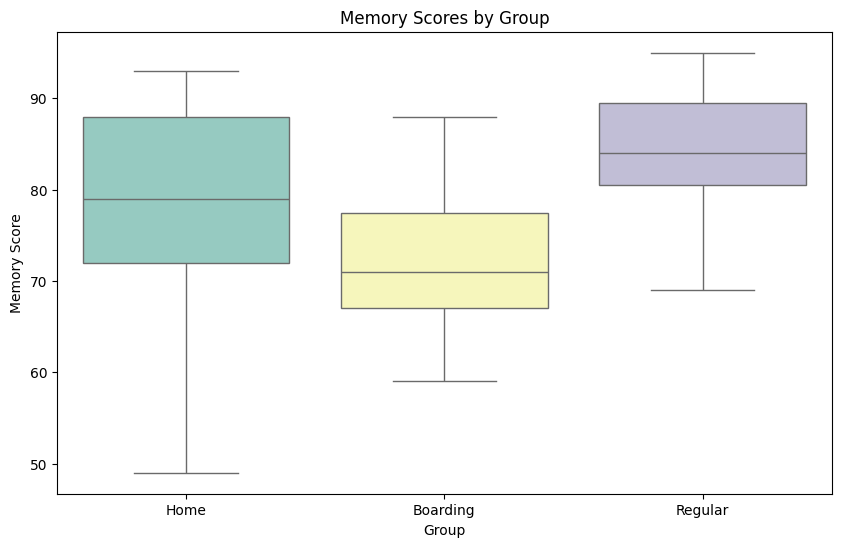

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', hue='variable', data=data.melt(), palette="Set3", legend=False)
plt.title('Memory Scores by Group')
plt.xlabel('Group')
plt.ylabel('Memory Score')
plt.show()